In [2]:
# all the packages you need
from __future__ import division
import sys
import numpy as np
import time
import scipy.io as io
import scipy.sparse as sparse
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# synthetic data generator
# n is number of samples, d is number of dimensions, k is number of nonzeros in w, sigma is std of noise, 
# X is a n x d data matrix, y=Xw+w_0+noise is a n-dimensional vector, w is the true weight vector, w0 is true intercept
def DataGenerator(n = 50, d = 75, k = 5, sigma = 1.0, w0 = 0.0, seed = 256):
    
    np.random.seed(seed)
    X = np.random.normal(0,1,(n,d))
    w = np.random.binomial(1,0.5,k)
    noise = np.random.normal(0,sigma,n)
    w[w == 1] = 10.0
    w[w == 0] = -10.0
    w = np.append(w, np.zeros(d - k))
    y = X.dot(w) + w0 + noise
    return (X, y, w, w0)

In [4]:
# initialization of W for lasso by least square regression or ridge regression
def Initialw(X, y):

    n, d = X.shape
    # increment X
    if sparse.issparse(X):
        XI = sparse.hstack((X, np.ones(n).reshape(n,1)))
    else:
        XI = np.hstack((X, np.ones(n).reshape(n,1)))

    if sparse.issparse(X):
        if n >= d:
            w = sparse.linalg.lsqr(XI, y)[0]
        else:
            w = sparse.linalg.inv(XI.T.dot(XI) + 1e-3 * sparse.eye(d+1)).dot(XI.T.dot(y))
            w = w.T
    else:
        if n >= d:
            w = np.linalg.lstsq(XI, y)[0]
        else:
            w = np.linalg.inv(XI.T.dot(XI) + 1e-3 * np.eye(d+1)).dot(XI.T.dot(y))
 
    return (w[:d], w[d])

In [5]:
# Helper and example function of sparse matrix operation for Problem 2.5
# W: a scipy.sparse.csc_matrix
# x: a vector with length equal to the number of columns of W
# In place change the data stored in W,
# so that every row of W gets element-wise multiplied by x
def cscMatInplaceEleMultEveryRow(W, x):
    indptr = W.indptr
    last_idx = indptr[0]
    for col_id, idx in enumerate(indptr[1:]):
        if idx == last_idx:
            continue
        else:
            W.data[last_idx:idx] *= x[col_id]
            last_idx = idx
    return W

In [6]:
def precalculate_a(X: np.ndarray) -> np.ndarray:
    
    n,d = X.shape
    a = np.zeros((d,))
    for k in range (d):
        for i in range (n):
            a[k] = a[k] + (X[i][k]**2)
    return a


In [7]:
# Problem 3(a).
# TODO: coordinate descent of lasso, note lmda stands for lambda

def soft_thresholding(kc, lmda, ka):
    if kc < -lmda:
        return (kc + lmda) / ka
    elif kc > lmda:
        return (kc - lmda) / ka
    else:
        return 0

def lasso(X, y, lmda=10.0, epsilon=1.0e-2, max_iter=100, draw_curve=False):
    weight, b = Initialw(X, y)
    i = 0
    prev_weight = np.zeros(X.shape[1])
    a = precalculate_a(X)
    loss_hist = []
    while True:
        for j in range(X.shape[1]):
            # update weight j
            cj = np.dot(X[:, j].T, y - (b + np.dot(X, weight) - weight[j] * X[:, j]))
            weight[j] = soft_thresholding(cj, lmda, a[j])
        
        # update intercept
        b = np.mean(y - np.dot(X, weight))
        
        # calculate loss
        loss = np.sum((b + np.dot(X, weight) - y)**2) / 2 + lmda*np.sum(np.abs(weight))
        loss_hist.append(loss)
        
        # check stopping criteria
        if np.max(np.abs(weight - prev_weight)) < epsilon or i >= max_iter:
            break
            
        prev_weight = weight.copy()
        i += 1
        
        
    return weight, b, i, loss_hist


In [8]:
# Problem 3(a): data generation
X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=1.0)
# have a look at generated data and true model
print(w_true)

[ 10. -10. -10.  10.  10.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.]


[ 9.65481376 -9.56314564 -9.57315242  9.62911069  9.77971154  0.
  0.          0.          0.          0.          0.          0.
  0.01394215  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.16980104  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.        ]
0.19123363726767287
903.0977230293004


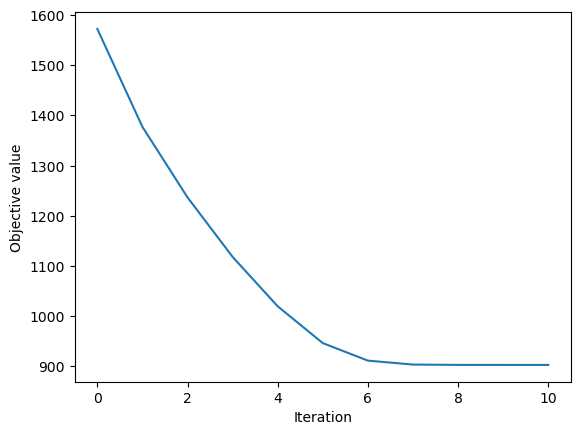

(75,)


In [14]:
# Problem 3(a): run lasso and plot the convergence curve
# TODO: run lasso for one synthetic data
w_lasso, w0_lasso, i, loss_hist = lasso(X, y, lmda = 18, epsilon = 1.0e-2, max_iter = 100, draw_curve = True)
# have a look at the lasso model you got (sparse? where?)
print(w_lasso)
print(w0_lasso)
print(loss_hist[-1])
plt.plot(loss_hist)
plt.xlabel('Iteration')
plt.ylabel('Objective value')
plt.show()
print(w_lasso.shape)

In [15]:
# Problem 3(b):
# TODO: evaluation function of lasso model
def root_mean_square_error(pred, y):
    #TODO
    rmse = np.sqrt((np.sum((y - pred)**2))*(1/len(y)))
    return rmse

def Evaluate(X, y, w, w0, w_true, w0_true):
    #########TODO##########
    # Find indices of nonzero entries in w and w0
    nonzero_w = np.nonzero(w)[0]
    nonzero_w_true = np.nonzero(w_true)[0]
    
    common_samples = set(nonzero_w).intersection(set(nonzero_w_true))
    precision_w = len(common_samples) / len(nonzero_w)
    recall_w = len(common_samples) / len(nonzero_w_true)
    
    sparsity_w = len(nonzero_w)
    
    pred = X @ w + w0
    rmse = root_mean_square_error(pred,y)
    
    return (rmse, sparsity_w, precision_w, recall_w)

In [16]:
# Problem 3(b)
# TODO: apply your evaluation function to compute precision (of w), recall (of w), sparsity (of w) and training RMSE
rmse, sparsity, precision, recall = Evaluate(X, y, w_lasso, w0_lasso, w_true, w0_true)
print("RMSE: ",rmse)
print("Sparsity: ", sparsity)
print("Precision: ", precision)
print("Recall: ", recall)

RMSE:  1.134751651855675
Sparsity:  7
Precision:  0.7142857142857143
Recall:  1.0


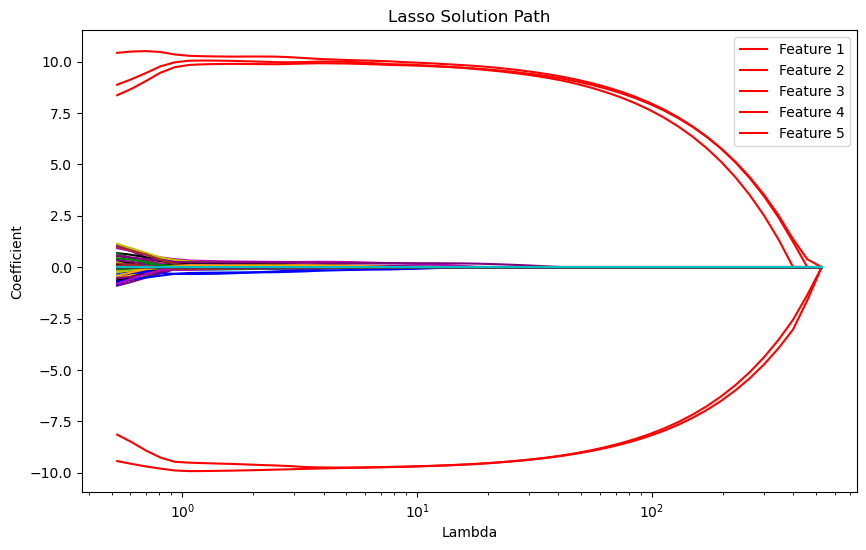

In [17]:
# Problem 3(c), first part
# TODO: compute a lasso solution path, draw the path(s) in a 2D plot

def LassoPath(X, y):
    lmda_max = np.max(np.abs((np.dot(X.T,(y - np.mean(y))))))
    lmda_min = 0
    Lmda = np.arange(lmda_min, lmda_max, 50)
    lambda_values = np.logspace(np.log10(lmda_max), np.log10(0.001*lmda_max), num=50)
    W = np.zeros((X.shape[1], len(lambda_values)))
    W0 = np.zeros((X.shape[1], 1))
    for i, lmda in enumerate(lambda_values):
        w, b, _, _ = lasso(X, y, lmda=lmda)
        W[:, i] = w
        W0[i, :] = b

    # Plot the solution path for each entry of theta
    plt.figure(figsize=(10, 6))
    colors = ['b', 'g', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']
    for i in range(0,5):
        plt.plot(lambda_values, W[i], color='r', label=f'Feature {i+1}')
        plt.legend()
    for i in range(5,X.shape[1]):
        plt.plot(lambda_values, W[i], color=colors[i%len(colors)], label=f'Feature {i+1}')
    plt.xscale('log')
    plt.xlabel('Lambda')
    plt.ylabel('Coefficient')
    plt.title('Lasso Solution Path')
    plt.show()
 

    return (W, W0, Lmda)
W, W0, lmdas = LassoPath(X,y)


In [18]:
# Problem 3(c), second part:
# TODO: evaluate a given lasso solution path, draw plot of precision/recall vs. lambda
def EvaluatePath(X, y, W, W0, w_true, w0_true, Lmda): #lambda_values):#
    #########TODO##########
    N= len(Lmda)
    precision = np.zeros(N)
    recall = np.zeros(N)
    rmse = np.zeros(N)
    sparsity = np.zeros(N)
    
    for i in range(N):
        w = W[:, i]
        w0 = W0[i,0]
        nonzero_w = np.nonzero(w)[0]
        nonzero_w_true = np.nonzero(w_true)[0]
    
        common_samples = set(nonzero_w).intersection(set(nonzero_w_true))
        if len(nonzero_w) == 0:
            precision[i] = 0
        else:
            precision[i] = len(common_samples) / len(nonzero_w)
        recall[i] = len(common_samples) / len(nonzero_w_true)
    
        sparsity[i] = len(nonzero_w)
    
        pred = X @ w + w0
        rmse[i] = root_mean_square_error(pred,y)
    
    RMSE = rmse
    Sparsity = sparsity
    Precision = precision
    Recall = recall
    lambda_values = Lmda
    fig, ax = plt.subplots()
    ax.plot(lambda_values, Precision, label='Precision')
    ax.plot(lambda_values, Recall, label='Recall')
    ax.set_xscale('log')
    ax.set_xlabel('Lambda')
    ax.set_ylabel('Precision/Recall')
    ax.legend()
    plt.show()

    return (RMSE, Sparsity, Precision, Recall, lambda_values)

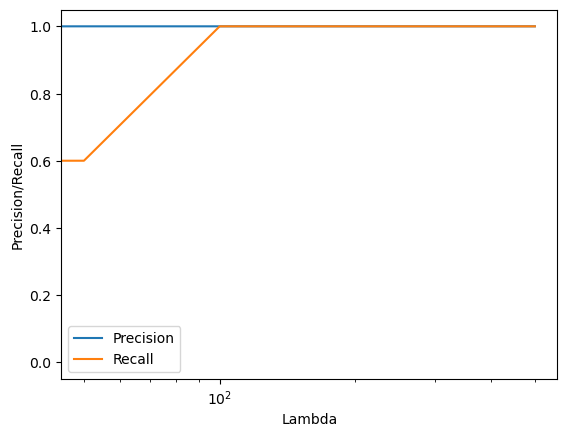

[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [19]:
RMSE, Sparsity, Precision, Recall, lambdas = EvaluatePath(X, y, W, W0, w_true, w0_true, lmdas)
print(Precision)

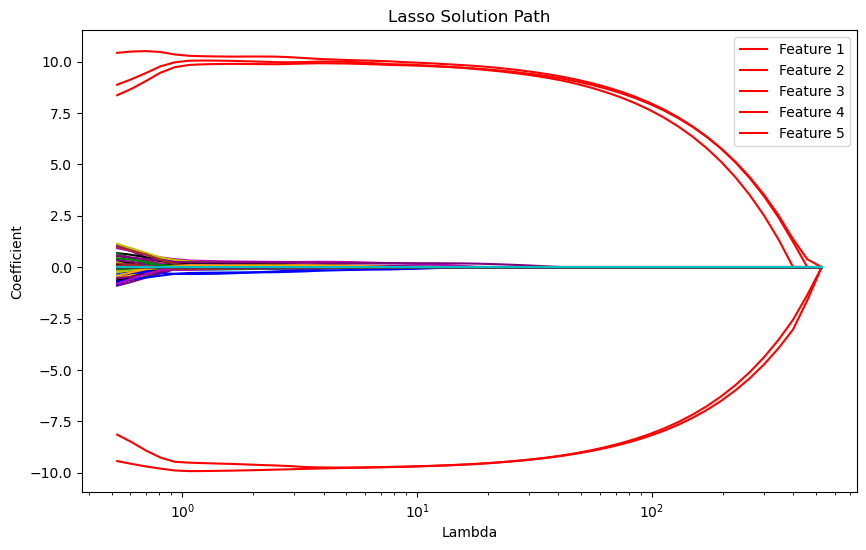

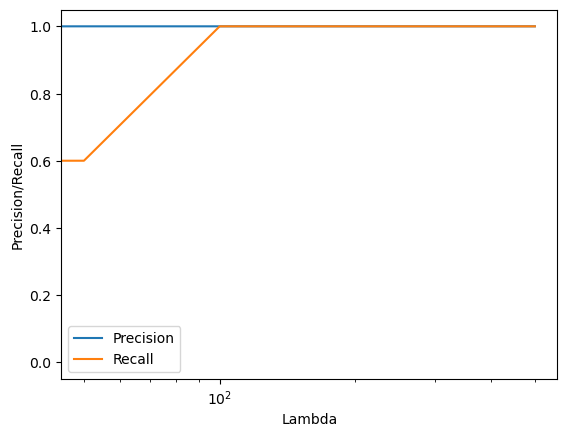

F1 score:  [0.  0.8 1.  1.  1.  1.  1.  1.  1.  1.  1. ]


In [20]:
# Problem 3(c), third part:
# TODO: draw lasso solution path and precision/recall vs. lambda curves
X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=1.0)
w_l, w0_l, lmda1 = LassoPath(X, y)

RMSE, Sparsity, Precision, Recall, lmda2 = EvaluatePath(X, y, w_l, w0_l, w_true, w0_true, lmda1)

F1_score = (Precision + Recall) / 2
print("F1 score: ", F1_score)


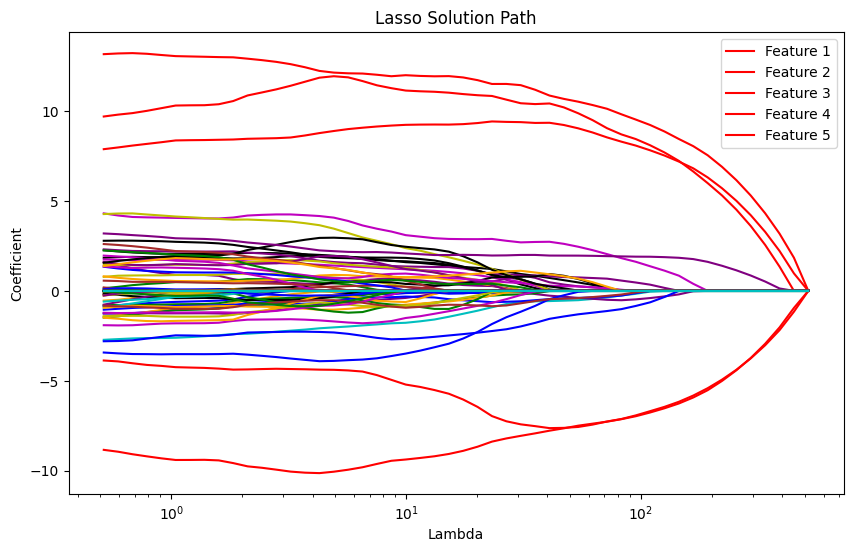

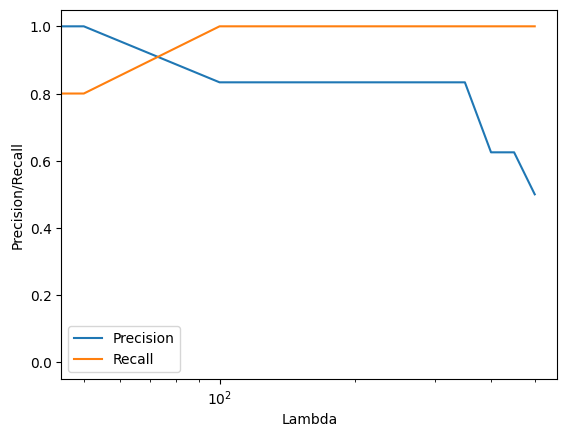

F1 score:  [0.         0.9        0.91666667 0.91666667 0.91666667 0.91666667
 0.91666667 0.91666667 0.8125     0.8125     0.75      ]


In [31]:
# Problem 3(c), noise standard deviation:
# TODO: try a larger std sigma = 10.0
X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=10.0)
w_l, w0_l, lmda1 = LassoPath(X, y)

RMSE, Sparsity, Precision, Recall, lmda2 = EvaluatePath(X, y, w_l, w0_l, w_true, w0_true, lmda1)
F1_score = (Precision + Recall) / 2
print("F1 score: ", F1_score)

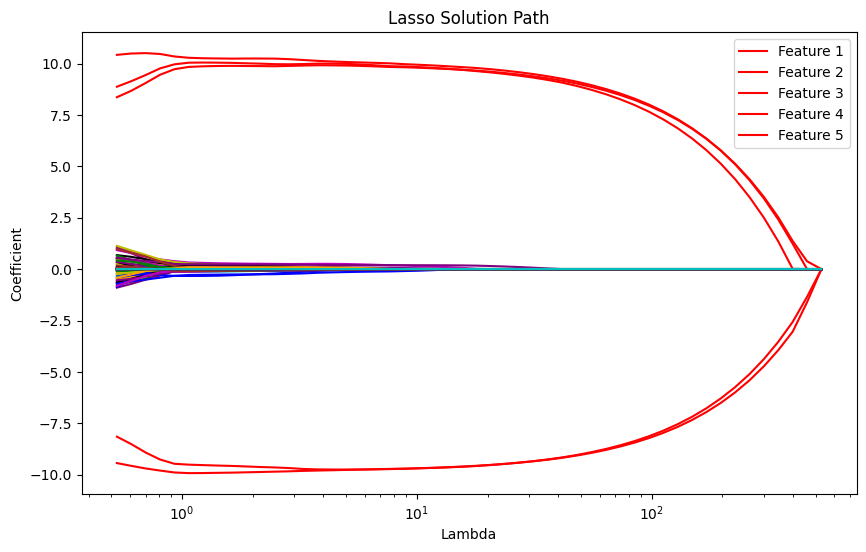

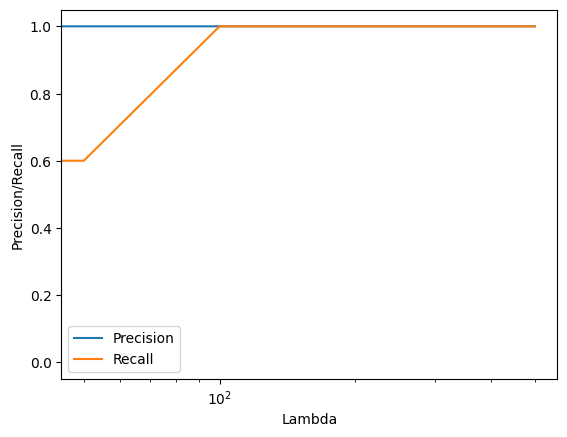

F1 score:  [0.  0.8 1.  1.  1.  1.  1.  1.  1.  1.  1. ]


In [33]:
# Problem 3(d):
# TODO: try another different choices of (n,m) 
# draw lasso solution path and precision/recall vs. lambda curves, use them to estimate the lasso sample complexity
X, y, w_true, w0_true = DataGenerator(n=50, d=75, k=5, sigma=1.0)
w_l, w0_l, lmda1 = LassoPath(X, y)

RMSE, Sparsity, Precision, Recall, lmda2 = EvaluatePath(X, y, w_l, w0_l, w_true, w0_true, lmda1)
F1_score = (Precision + Recall) / 2
print("F1 score: ", F1_score)

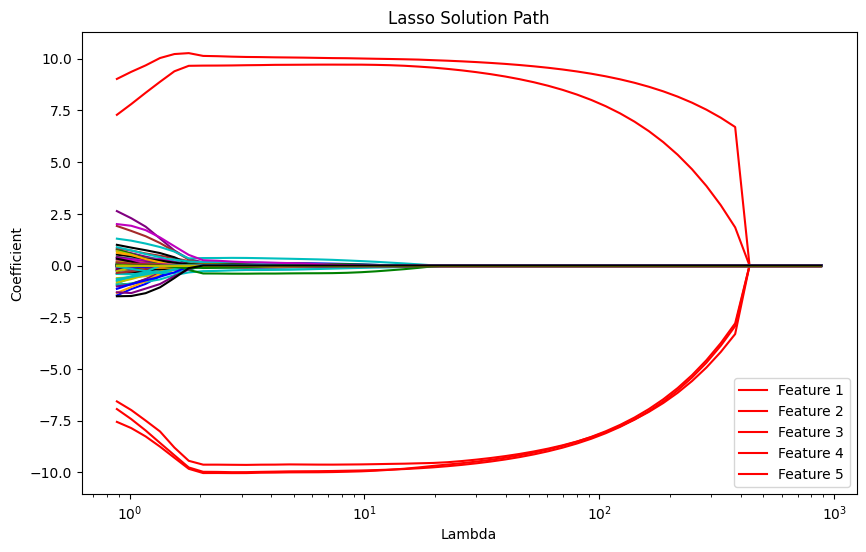

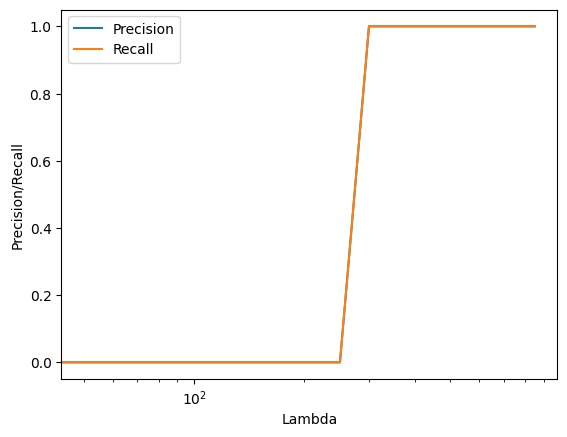

F1 score:  [0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [40]:
# Problem 3(d):
# TODO: try another different choices of (n,m) 
# draw lasso solution path and precision/recall vs. lambda curves, use them to estimate the lasso sample complexity
X, y, w_true, w0_true = DataGenerator(n=50, d=150, k=5, sigma=1.0)
w_l, w0_l, lmda1 = LassoPath(X, y)

RMSE, Sparsity, Precision, Recall, lmda2 = EvaluatePath(X, y, w_l, w0_l, w_true, w0_true, lmda1)
F1_score = (Precision + Recall) / 2
print("F1 score: ", F1_score)

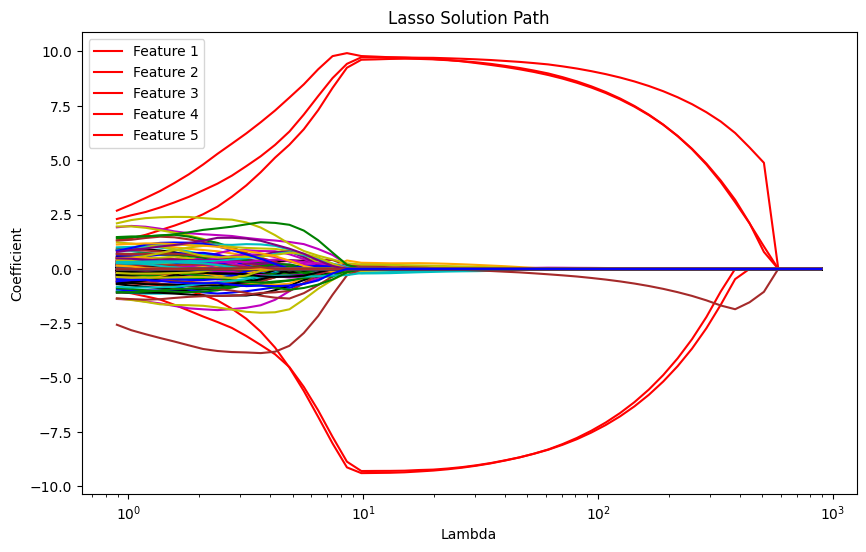

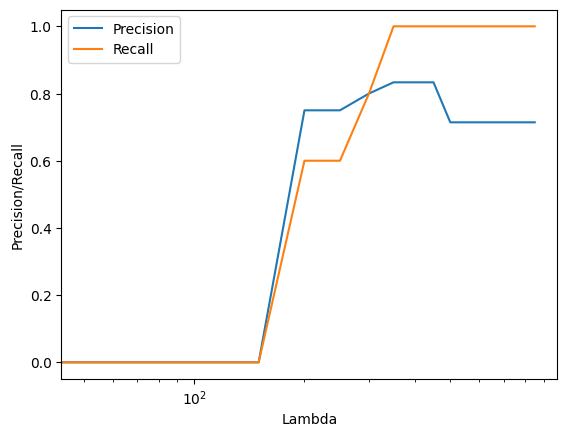

F1 score:  [0.         0.         0.         0.         0.675      0.675
 0.8        0.91666667 0.91666667 0.91666667 0.85714286 0.85714286
 0.85714286 0.85714286 0.85714286 0.85714286 0.85714286 0.85714286]


In [35]:
# Problem 3(d):
# TODO: try another different choices of (n,m) 
# draw lasso solution path and precision/recall vs. lambda curves, use them to estimate the lasso sample complexity
X, y, w_true, w0_true = DataGenerator(n=50, d=1000, k=5, sigma=1.0)
w_l, w0_l, lmda1 = LassoPath(X, y)

RMSE, Sparsity, Precision, Recall, lmda2 = EvaluatePath(X, y, w_l, w0_l, w_true, w0_true, lmda1)
F1_score = (Precision + Recall) / 2
print("F1 score: ", F1_score)

/var/folders/k0/21yc9wv13vs841ytt4r8yxyr0000gn/T/ipykernel_41929/3894678280.py:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = np.linalg.lstsq(XI, y)[0]


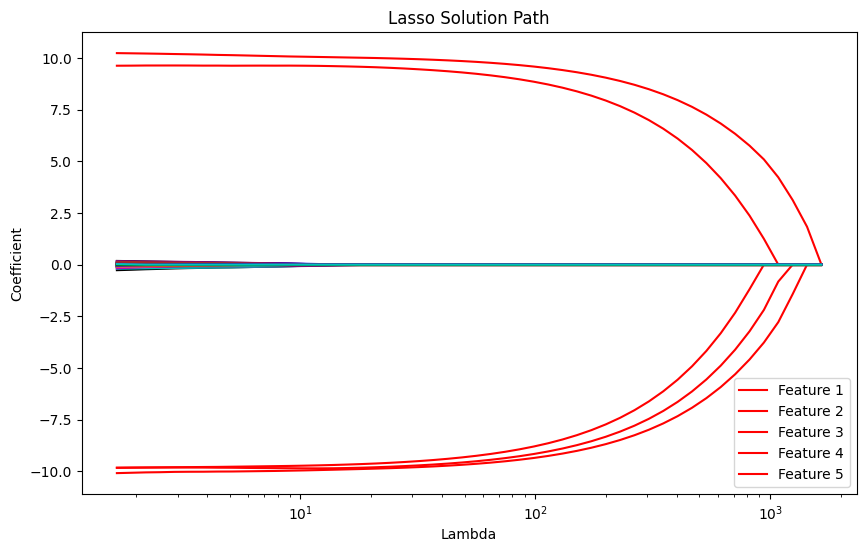

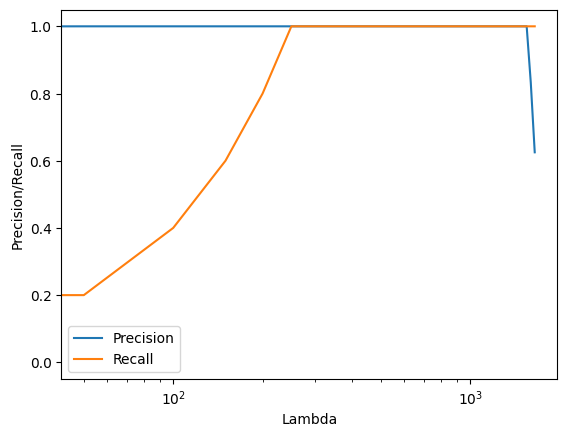

F1 score:  [0.         0.6        0.7        0.8        0.9        1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         0.91666667 0.8125    ]


In [36]:
# Problem 3(d):
# TODO: try another different choices of (n,m) 
# draw lasso solution path and precision/recall vs. lambda curves, use them to estimate the lasso sample complexity
X, y, w_true, w0_true = DataGenerator(n=100, d=75, k=5, sigma=1.0)
w_l, w0_l, lmda1 = LassoPath(X, y)

RMSE, Sparsity, Precision, Recall, lmda2 = EvaluatePath(X, y, w_l, w0_l, w_true, w0_true, lmda1)
F1_score = (Precision + Recall) / 2
print("F1 score: ", F1_score)

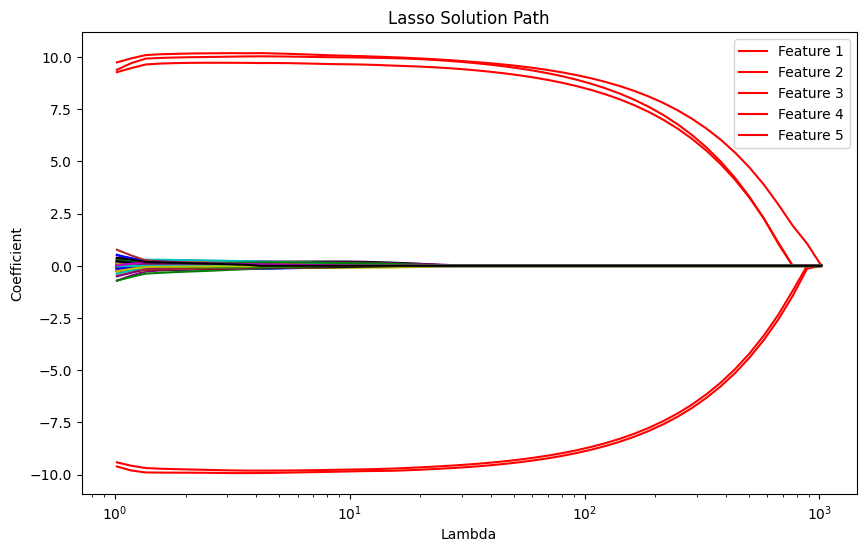

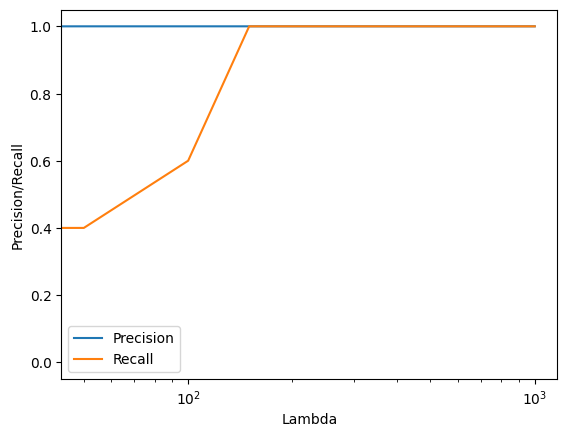

F1 score:  [0.  0.7 0.8 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1.  1.  1. ]


In [37]:
# Problem 3(d):
# TODO: try another different choices of (n,m) 
# draw lasso solution path and precision/recall vs. lambda curves, use them to estimate the lasso sample complexity
X, y, w_true, w0_true = DataGenerator(n=100, d=150, k=5, sigma=1.0)
w_l, w0_l, lmda1 = LassoPath(X, y)

RMSE, Sparsity, Precision, Recall, lmda2 = EvaluatePath(X, y, w_l, w0_l, w_true, w0_true, lmda1)
F1_score = (Precision + Recall) / 2
print("F1 score: ", F1_score)

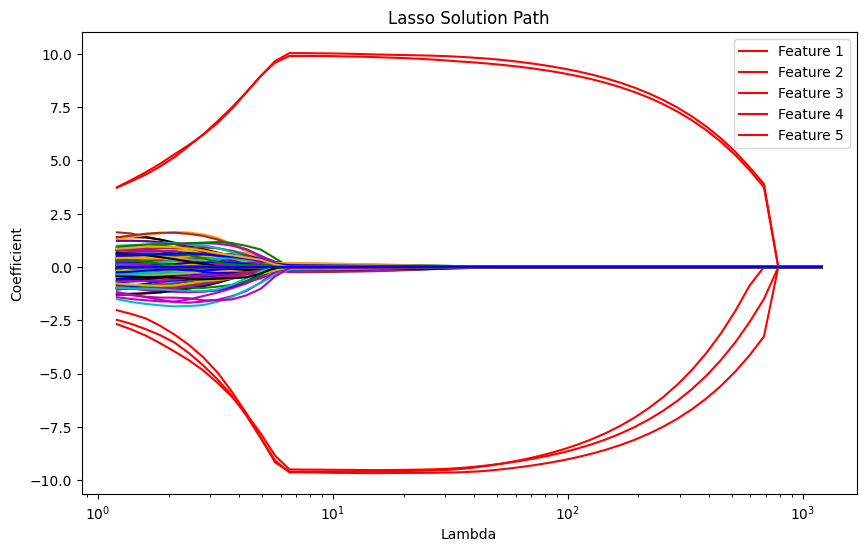

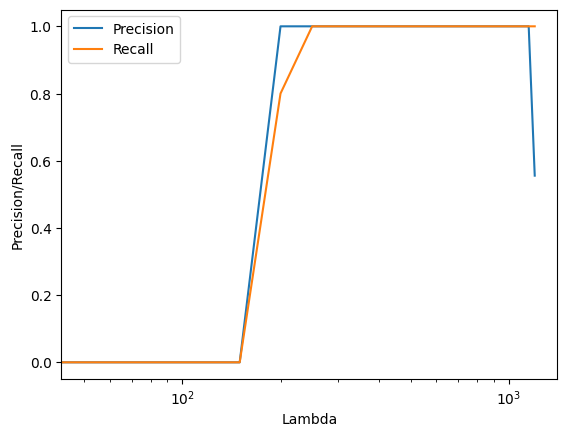

F1 score:  [0.         0.         0.         0.         0.9        1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 0.77777778]


In [38]:
# Problem 3(d):
# TODO: try another different choices of (n,m) 
# draw lasso solution path and precision/recall vs. lambda curves, use them to estimate the lasso sample complexity
X, y, w_true, w0_true = DataGenerator(n=100, d=1000, k=5, sigma=1.0)
w_l, w0_l, lmda1 = LassoPath(X, y)

RMSE, Sparsity, Precision, Recall, lmda2 = EvaluatePath(X, y, w_l, w0_l, w_true, w0_true, lmda1)
F1_score = (Precision + Recall) / 2
print("F1 score: ", F1_score)

In [41]:
# Problem 3(e): predict reviews' star on Yelp
# data parser reading yelp data
def DataParser(Xfile, yfile, nfile, train_size = 4000, valid_size = 1000):

    # read X, y, feature names from file
    fName = open(nfile).read().splitlines()
    y = np.loadtxt(yfile, dtype=int)
    if Xfile.find('mtx') >= 0:
        # sparse data
        X = io.mmread(Xfile).tocsc()
    else:
        # dense data
        X = np.genfromtxt(Xfile, delimiter=",")

    # split training, validation and test set
    X_train = X[0 : train_size,:]
    y_train = y[0 : train_size]
    X_valid = X[train_size : train_size + valid_size,:]
    y_valid = y[train_size : train_size + valid_size]
    X_test = X[train_size + valid_size : np.size(X,0),:]
    y_test = y[train_size + valid_size : np.size(y,0)]

    return (X_train, y_train, X_valid, y_valid, X_test, y_test, fName)



In [42]:
# Set the file paths
Xfile = "star_data.mtx"
yfile = "star_labels.txt"
nfile = "star_features.txt"

# Set the sizes for the training, validation, and test sets
train_size = 30000
valid_size = 5000

# Parse the data
X_train, y_train, X_valid, y_valid, X_test, y_test, feature_names = DataParser(Xfile, yfile, nfile, train_size, valid_size)

In [43]:
print("X_train shape: ",X_train.shape)
print("y_train shape: ",y_train.shape)
print("X_valid shape: ",X_valid.shape)
print("y_valid shape: ",y_valid.shape)
print("X_test shape: ",X_test.shape)
print("y_test shape: ",y_test.shape)

X_train shape:  (30000, 2500)
y_train shape:  (30000,)
X_valid shape:  (5000, 2500)
y_valid shape:  (5000,)
X_test shape:  (10000, 2500)
y_test shape:  (10000,)


In [44]:
X_t = sparse.csc_matrix(X_train)
print(X_t.shape)

def precalculate_a(X: np.ndarray) -> np.ndarray:
    n,d = X.shape
    a = np.zeros((d,))
    for k in range (d):
        for i in range (n):
            a[k] = a[k] + (X[i][k]**2)
    return a

a1 = sum(X_t.multiply(X_t))
print(a1.shape)

(30000, 2500)
(1, 2500)


In [18]:
X_train_sample, y_train_sample, X_valid_sample, y_valid_sample, X_test_sample, y_test_sample, feature_names_sample = DataParser(Xfile, yfile, nfile, 5000, 1000)


In [51]:
def soft_thresholding(kc, lmda, ka):
    ka_recip = sparse.linalg.inv(ka)
    if kc < -lmda:
        s_t = (kc + lmda)*ka_recip
        return s_t
    elif kc > lmda:
        s_t = (kc - lmda)*ka_recip
        return s_t
    else:
        return 0
    
    
def get_sparse_w0(w0,n):
    scalar = w0
    l = np.zeros((n,1))
    l = l+scalar
    k = sparse.csc_matrix(l, shape = (n,1))
    return k

def lasso_coordinate_descent(X, y, lmda=10.0, epsilon=1.0e-2, max_iter=100, draw_curve=False):
    w,w0 = Initialw(X,y)
    n, m = X.shape
    prev_weight = np.zeros(m)
    X = sparse.csc_matrix(X)
    y = sparse.csc_matrix(y)
    #y = y.reshape(-1,1)
    i = 0
    a =  sum(X.multiply(X)).T
    loss_hist = []
    while True:
            for j in range(m):
                w.reshape(-1,1)
                Xw = X.dot(w)
                #Xw = cscMatInplaceEleMultEveryRow(Xtemp, w)
                Xw = Xw.reshape(-1,1)
                Xj = X.getcol(j)
                w0_sparse = get_sparse_w0(w0,n)
            
                y = y.reshape(-1,1)
                cj_two = y - (w0_sparse + Xw - Xj.multiply(w[j]))
                cj_one = Xj.T
                cj = cj_one.dot(cj_two)
                #cj = cj.toarray()[0][0]
                w[j] = soft_thresholding(cj, lmda, a.getrow(j))   #numpy array
                #print("w[j]: ",w[j])
            
            #Xw1 = cscMatInplaceEleMultEveryRow(Xtemp1, w)
            Xw1 = X.dot(w)
            Xw1 = Xw1.reshape(-1,1)
            w0 = sparse.csc_matrix.mean(y - Xw1)
            w0_sparse1 = get_sparse_w0(w0,n)
            #calculate loss
            #temp = sum((w0_sparse1 + Xw1 - y).multiply((w0_sparse1 + Xw1 - y)))
            temp = sum(((w0_sparse1 + Xw1 - y).T).dot(w0_sparse1 + Xw1 - y))
            print(type(temp))
            #temp = temp.toarray()[0][0]
            loss = temp/2 + lmda*np.sum(np.abs(w))
            #loss = sum((w0 + Xw1 - y).multiply((w0 + Xw1 - y))) / 2 + lmda*np.sum(np.abs(w))
            loss_hist.append(loss)
            
            #stopping criteria
            if np.max(np.abs(w - prev_weight)) < epsilon or i >= max_iter:
                print("last iter num: ",i)
                break
                

            prev_weight = w.copy()
            i += 1
            #print("iteration number: ",i)
        
        
    return w, w0, i, loss_hist


In [48]:
w_train, w0_train, i_train, loss_train = lasso_coordinate_descent(X_train, y_train, lmda=0.1, epsilon=1.0e-2, max_iter=100, draw_curve=False)

<class 'numpy.matrix'>
iteration number:  1
<class 'numpy.matrix'>
iteration number:  2
<class 'numpy.matrix'>
iteration number:  3
<class 'numpy.matrix'>
iteration number:  4
<class 'numpy.matrix'>
iteration number:  5
<class 'numpy.matrix'>
iteration number:  6
<class 'numpy.matrix'>
iteration number:  7
<class 'numpy.matrix'>
iteration number:  8
<class 'numpy.matrix'>
iteration number:  9
<class 'numpy.matrix'>
iteration number:  10
<class 'numpy.matrix'>
iteration number:  11
<class 'numpy.matrix'>
iteration number:  12
<class 'numpy.matrix'>
iteration number:  13
<class 'numpy.matrix'>
iteration number:  14
<class 'numpy.matrix'>
iteration number:  15
<class 'numpy.matrix'>
iteration number:  16
<class 'numpy.matrix'>
iteration number:  17
<class 'numpy.matrix'>
iteration number:  18
<class 'numpy.matrix'>
iteration number:  19
<class 'numpy.matrix'>
iteration number:  20
<class 'numpy.matrix'>
iteration number:  21
<class 'numpy.matrix'>
iteration number:  22
<class 'numpy.matri

[ 1.16872397 -0.89745831 -0.75314521 ...  0.97923528 -1.48834416
 -3.52520714]
3.764248036705668
610.505851239907


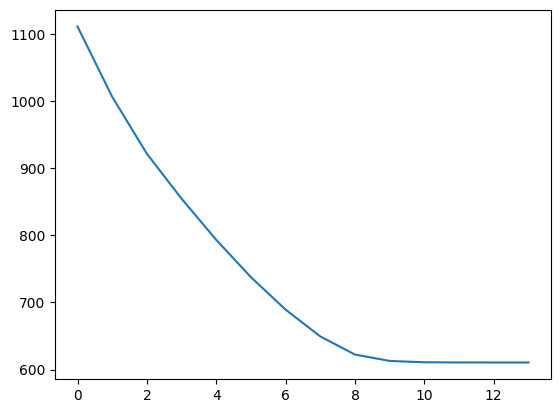

In [49]:
print(w_train)
print(w0_train)
print(loss_hist[-1])
plt.plot(loss_hist)

In [52]:
lmdamax_two = y_train - np.mean(y_train)
lmdamax_one = X_train.T
lmda_max_dot = lmdamax_one.dot(lmdamax_two)
lmdamax_abs = np.abs(lmda_max_dot)
lmda_max1 = np.max(lmdamax_abs)
lmda_min1 = 0.08*lmda_max1
Lmda = np.arange(lmda_min1, lmda_max1, 20)
lambda_values1 = np.logspace(np.log10(lmda_max1), np.log10(0.001*lmda_max1), num=20)
print(lambda_values1)

[39.57825401 27.51451708 19.12789406 13.29757416  9.24437776  6.42662482
  4.46774328  3.10594294  2.15922916  1.50108056  1.04354039  0.72546176
  0.50433579  0.35061061  0.24374197  0.16944766  0.11779879  0.08189287
  0.05693134  0.03957825]


<class 'numpy.matrix'>
<class 'numpy.matrix'>
<class 'numpy.matrix'>
<class 'numpy.matrix'>
<class 'numpy.matrix'>
<class 'numpy.matrix'>
<class 'numpy.matrix'>
last iter num:  6
<class 'numpy.matrix'>
<class 'numpy.matrix'>
<class 'numpy.matrix'>
<class 'numpy.matrix'>
<class 'numpy.matrix'>
<class 'numpy.matrix'>
<class 'numpy.matrix'>
<class 'numpy.matrix'>
<class 'numpy.matrix'>
<class 'numpy.matrix'>
<class 'numpy.matrix'>
last iter num:  10
<class 'numpy.matrix'>
<class 'numpy.matrix'>
<class 'numpy.matrix'>
<class 'numpy.matrix'>
<class 'numpy.matrix'>
<class 'numpy.matrix'>
<class 'numpy.matrix'>
<class 'numpy.matrix'>
<class 'numpy.matrix'>
<class 'numpy.matrix'>
<class 'numpy.matrix'>
<class 'numpy.matrix'>
<class 'numpy.matrix'>
<class 'numpy.matrix'>
<class 'numpy.matrix'>
<class 'numpy.matrix'>
<class 'numpy.matrix'>
<class 'numpy.matrix'>
<class 'numpy.matrix'>
<class 'numpy.matrix'>
<class 'numpy.matrix'>
<class 'numpy.matrix'>
<class 'numpy.matrix'>
<class 'numpy.matrix

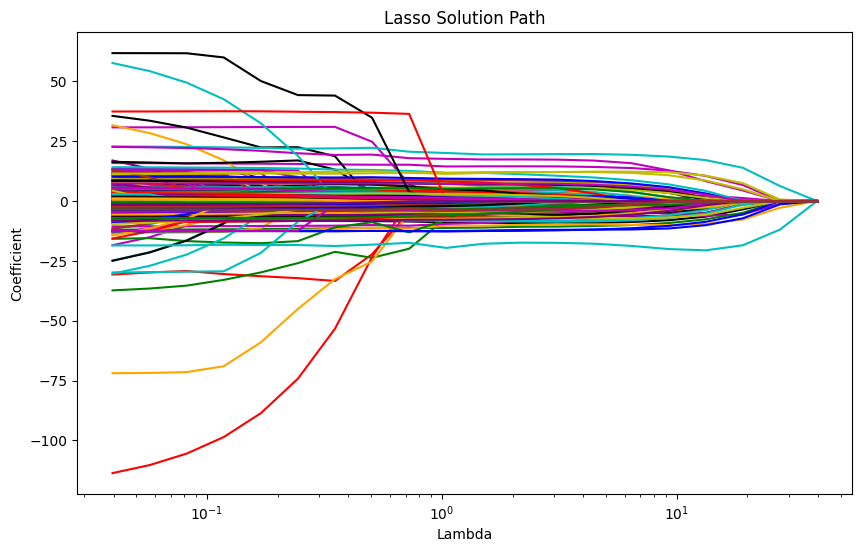

In [53]:
def Lasso_soln_path(X_train, y_train):
    #########TODO##########
    #lambda_values, Lmda = lambda_values_der(X_train,y_train)
    W_train = np.zeros((X_train.shape[1], len(lambda_values1)))
    W0_train = np.zeros((20, 1))#(20,1)
    for i, lmda in enumerate(lambda_values1):
        w, b, _, _ = lasso_coordinate_descent(X_train, y_train, lmda=lmda, epsilon=1.0e-2, max_iter=100, draw_curve=False)
        W_train[:,i] = w
        W0_train[i,:] = b #i put W0 earlier
        
        # Plot the solution path for each entry of theta
    plt.figure(figsize=(10, 6))
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']
    for i in range(X_train.shape[1]):
        plt.plot(lambda_values1, W_train[i], color=colors[i%len(colors)], label=f'Feature {i+1}')
    plt.xscale('log')
    plt.xlabel('Lambda')
    plt.ylabel('Coefficient')
    plt.title('Lasso Solution Path')
    #plt.legend()
    plt.show()

    return (W_train, W0_train)
W, W0 = Lasso_soln_path(X_train,y_train)    

In [78]:
np.save('W.npy',W)
np.save('W0.npy',W0)

In [79]:
W = np.load('W.npy')
W0 = np.load('W0.npy')

In [80]:
# RMSE = []

# for i in range(0,20):
#     y_pred = X_train @ W[:,i] + W0[i]
#     rmse = root_mean_square_error(y_pred, y_train)
#     RMSE.append(rmse)
    
# print(RMSE)
# print(min(RMSE))
# print(RMSE[10])
# def find_index(arr, val):
#     for i in range(len(arr)):
#         if arr[i] == val:
#             return i
#     return -1

# i_min = find_index(RMSE, min(RMSE))
# print(i_min)
# print(lambda_values1[10])

In [73]:
# Problem 3(e): predict reviews' star on Yelp
# TODO: evaluation funtion that computes the lasso path, evaluates the result, and draws the required plots
def find_index(arr, val):
    for i in range(len(arr)):
        if arr[i] == val:
            return i
    return -1

def Validation(X_train, y_train, X_valid, y_valid):
    #########TODO##########
    
    RMSE_train = []
    RMSE_valid = []
    for i in range(0,20):
        y_pred_train = X_train @ W[:,i] + W0[i]
        rmse_train = root_mean_square_error(y_pred_train, y_train)
        RMSE_train.append(rmse_train)
        y_pred_valid = X_valid @ W[:,i] + W0[i]
        rmse_valid = root_mean_square_error(y_pred_valid, y_valid)
        RMSE_valid.append(rmse_valid)
        
    print("Minimum of RMSE train: ",min(RMSE_train))
    print("Minimum of RMSE valid: ",min(RMSE_valid))
    
    index_train = find_index(RMSE_train, min(RMSE_train))
    #print("RMSE_train minimum for lambda_value: ",lambda_values1[index_train])
    index_valid = find_index(RMSE_valid, min(RMSE_valid))
    print("RMSE_valid minimum for lambda_value: ", lambda_values1[index_valid])
    print("Its valid index: ", index_valid)
    lmda_best = lambda_values1[index_valid]
    w_lasso = W[:,index_valid]
    w0_lasso = W0[index_valid]
    fig1 = plt.plot(lambda_values1, RMSE_train)
    plt.title('RMSE (training set) vs lambda values')
    plt.xlabel('lambda')
    plt.ylabel('RMSE')
    #fig2 = plt.plot(lambda_values1, RMSE_valid)
    #plt.title('RMSE (validation set) vs lambda values')
    print("RMSE_train: ",RMSE_train)
    print("RMSE_valid: ", RMSE_valid)
    fig1
    #fig2
    return (w_lasso, w0_lasso, lmda_best)

Minimum of RMSE train:  0.9189667224425224
Minimum of RMSE valid:  0.9912358487184864
RMSE_valid minimum for lambda_value:  1.5010805576387316
Its valid index:  9
RMSE_train:  [1.2201586439552117, 1.1991583875311147, 1.1498065881122548, 1.1026926689401464, 1.0651980390296225, 1.0382434164951784, 1.018928914854012, 1.0016405060680127, 0.9846104017641064, 0.9681831910979042, 0.9535375588349215, 0.9413834692776037, 0.9330313506305766, 0.927488139031847, 0.9238186447758638, 0.9216163305553812, 0.9203266575861078, 0.9195852536224396, 0.9191804634441961, 0.9189667224425224]
RMSE_valid:  [1.2141998400557508, 1.1943082376066214, 1.1452202760060044, 1.096026124135542, 1.0580150901348981, 1.0312794313123927, 1.0139251153803193, 1.0023237012817323, 0.9942404381369137, 0.9912358487184864, 0.9925566515641197, 0.9979788904566348, 1.0054133865825075, 1.0147497367532907, 1.0228594258866024, 1.02965058483435, 1.0351456411959143, 1.0391898753241509, 1.042817975329107, 1.0454579406597868]


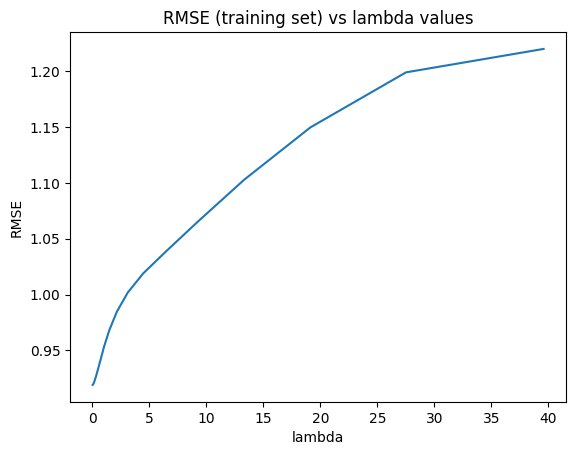

In [74]:
w_valid, w0_valid, lmda_best = Validation(X_train, y_train, X_valid, y_valid)

In [76]:
# report the corresponding test RMSE (on test set)
y_pred_test = X_test @ w_valid + w0_valid
rmse_test = root_mean_square_error(y_pred_test, y_test)
print("RMSE on test set: ",rmse_test)

RMSE on test set:  1.0980237007089602


In [ ]:
# Problem 3(e): predict reviews' star on Yelp
# TODO: evaluation of your results

# load Yelp data: change the address of data files on your own machine if necessary ('../data/' in the below)
from scipy.sparse.linalg import lsqr
X_train, y_train, X_valid, y_valid, X_test, y_test, fName = DataParser('../data/star_data.mtx', '../data/star_labels.txt', '../data/star_features.txt', 30000, 5000)


Minimum of RMSE train:  0.9189667224425224
Minimum of RMSE valid:  0.9912358487184864
RMSE_valid minimum for lambda_value:  1.5010805576387316
Its valid index:  9
RMSE_train:  [1.2201586439552117, 1.1991583875311147, 1.1498065881122548, 1.1026926689401464, 1.0651980390296225, 1.0382434164951784, 1.018928914854012, 1.0016405060680127, 0.9846104017641064, 0.9681831910979042, 0.9535375588349215, 0.9413834692776037, 0.9330313506305766, 0.927488139031847, 0.9238186447758638, 0.9216163305553812, 0.9203266575861078, 0.9195852536224396, 0.9191804634441961, 0.9189667224425224]
RMSE_valid:  [1.2141998400557508, 1.1943082376066214, 1.1452202760060044, 1.096026124135542, 1.0580150901348981, 1.0312794313123927, 1.0139251153803193, 1.0023237012817323, 0.9942404381369137, 0.9912358487184864, 0.9925566515641197, 0.9979788904566348, 1.0054133865825075, 1.0147497367532907, 1.0228594258866024, 1.02965058483435, 1.0351456411959143, 1.0391898753241509, 1.042817975329107, 1.0454579406597868]
Lasso select fe

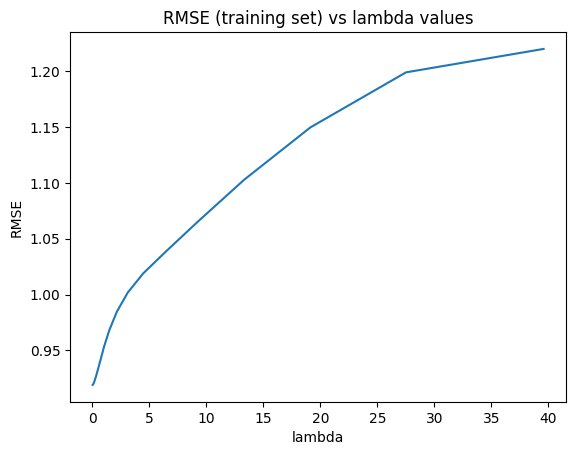

In [77]:
# evaluation
w_validlasso, w0_validlasso, lmda_best = Validation(X_train, y_train, X_valid, y_valid)

# print the top-10 features you found by lasso
idx = (-np.abs(w_validlasso)).argsort()[0:10]
fName = open(nfile).read().splitlines()
print('Lasso select features:')
for i in range(10):
    print(fName[idx[i]],w_validlasso[idx[i]])